## Churn Prediction

Build a basic churn prediction model based on this data – predict the probability of customer churn in the next 6 month from the latest date. The approach would matter here, not the accuracy. You should clearly explain what are the data sanity checks you’ll do, what parameters will you use to compare the models, how to measure the accuracy of the model – basically the entire end to end model cycle.

###

It is difficult to acquire new customers than to retain existing ones.

In [248]:
import pandas as pd
import numpy as np

import os
import datetime as dt
import utility_functions as uf

#Plotting related libraries
import matplotlib.pyplot as plt

#Modelling related libraries
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
import joblib

#Model Evaluation Libraries
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score

In [4]:
#Read the UK related clean data
uk_data_NA_free_cust = pd.read_csv(os.getcwd() + '/Statistics/UK_data_NA_free.csv')

#Unique customers = 3,950
uk_data_NA_free_cust.shape #(3,61,878 X 14)

(361878, 14)

In [5]:
RFM_data = pd.read_csv(os.getcwd() + '/Final_Data.csv')
if('Unnamed: 0' in RFM_data.columns):
    RFM_data = RFM_data.drop('Unnamed: 0', axis=1)
RFM_data.head()

,CustomerID,Days_SinceLastTxn,InvoiceNo Counts,Total Amount,R_Rank,F_Rank,M_Rank,R_Rank_nrm,R_Rank_score,F_Rank_nrm,F_Rank_score,M_Rank_nrm,M_Rank_score,RFM_score,Customer_Segments,Customer Tags
0,13113.0,3794,40,10510.00,16.0,35.0,71.0,0.0,0,0.010133,0,0.017726,0,0,2,Churned Customer
1,15804.0,3794,19,3848.55,16.0,149.0,311.0,0.0,0,0.044107,0,0.078501,0,0,2,Churned Customer
2,13777.0,3794,41,25748.35,16.0,32.5,29.0,0.0,0,0.009388,0,0.007090,0,0,2,Churned Customer
3,17581.0,3794,31,10736.11,16.0,55.0,67.0,0.0,0,0.016093,0,0.016713,0,0,2,Churned Customer
4,12748.0,3794,224,29072.10,16.0,1.0,22.0,0.0,0,0.000000,0,0.005318,0,0,2,Churned Customer


In [6]:
#3950
RFM_data.shape

(3950, 16)

In [7]:
#Ignore the variables 'M_Rank_score', 'R_Rank_score', 'F_Rank_score'
RFM_data[['M_Rank_score', 'R_Rank_score', 'F_Rank_score']].describe()

,M_Rank_score,R_Rank_score,F_Rank_score
count,3950.000000,3950.000000,3950.000000
mean,0.000253,0.003544,0.300759
std,0.015911,0.059436,0.458646
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


In [8]:
#Drop the variables ['M_Rank_score', 'R_Rank_score', 'F_Rank_score']
print(RFM_data.shape)
score_cols = ['M_Rank_score', 'R_Rank_score', 'F_Rank_score']

if(set(score_cols).intersection(set(RFM_data.columns)) == set(score_cols)):
    RFM_data = RFM_data.drop(score_cols, axis=1)

print(RFM_data.shape)

(3950, 16)
(3950, 13)


## Target Tagging

In [9]:
customer_tags = {0: 'New Customer', 1:'Best Customer', \
                 2:'Churned Customer', 3:'Risk of Leaving'}

RFM_data['Customer Tags'] = RFM_data['Customer_Segments'].map(customer_tags)

cust_seg_obj = uf.GetStats(RFM_data[['CustomerID', 'Customer Tags']])

cust_seg_obj.categorical_distribution('Customer Tags')

,Category,Counts,Percentage
0,Best Customer,1153,29.19
3,Churned Customer,1123,28.43
1,New Customer,918,23.24
2,Risk of Leaving,756,19.14


In [10]:
rfm_stats_obj = uf.GetStats(RFM_data)
rfm_stats = rfm_stats_obj.driver()
rfm_stats

,Features,Missing Value Count,Missing Value Percentage,Data Types,count,mean,std,min,25%,50%,75%,max,# Categories
0,CustomerID,0,0.0,float64,3950.0,15562.029367,1576.848325,12346.00,14208.250000,15571.500000,16913.750000,18287.00,NaN
1,Days_SinceLastTxn,0,0.0,int64,3950.0,3885.323038,100.236848,3794.00,3810.000000,3844.000000,3937.000000,4167.00,NaN
2,InvoiceNo Counts,0,0.0,int64,3950.0,5.027089,8.717306,1.00,1.000000,3.000000,5.000000,224.00,NaN
3,Total Amount,0,0.0,float64,3950.0,1713.385669,6548.608224,-4287.63,282.255000,627.060000,1521.782500,256438.49,NaN
4,R_Rank,0,0.0,float64,3950.0,1975.500000,1140.333924,16.00,965.000000,1991.500000,2962.500000,3943.50,NaN
5,F_Rank,0,0.0,float64,3950.0,1975.500000,1119.520204,1.00,1108.000000,1801.500000,3356.500000,3356.50,NaN
6,M_Rank,0,0.0,float64,3950.0,1975.500000,1140.411104,1.00,988.250000,1975.500000,2962.750000,3950.00,NaN
7,R_Rank_nrm,0,0.0,float64,3950.0,0.498918,0.290346,0.00,0.241630,0.502992,0.750223,1.00,NaN
8,F_Rank_nrm,0,0.0,float64,3950.0,0.588437,0.333637,0.00,0.329906,0.536582,1.000000,1.00,NaN
9,M_Rank_nrm,0,0.0,float64,3950.0,0.500000,0.288785,0.00,0.250000,0.500000,0.750000,1.00,NaN


## Independent Variables

1. Days_SinceLastTxn 	

2. InvoiceNo Counts 	

3. Total Amount

## Dependent Variable

Customer Tags

In [11]:
independent_vars = ['Days_SinceLastTxn', 'InvoiceNo Counts', 'Total Amount']
target_var = 'Customer Tags'
RFM_data[['CustomerID'] + independent_vars + [target_var]].head()

,CustomerID,Days_SinceLastTxn,InvoiceNo Counts,Total Amount,Customer Tags
0,13113.0,3794,40,10510.00,Churned Customer
1,15804.0,3794,19,3848.55,Churned Customer
2,13777.0,3794,41,25748.35,Churned Customer
3,17581.0,3794,31,10736.11,Churned Customer
4,12748.0,3794,224,29072.10,Churned Customer


## Predict Churn Probability

Strategy:-

Present:- Churn tags for the customers (given the recent date's input)

Get their input details 6 Months before recent date. This will serve as input for the model.
Customer Tags for the recent date will serve as output.

Training Data, Testing Data and Validation Data


In [12]:
#Read the recency file
recency = pd.read_csv(os.getcwd() + "/Statistics/Recency_Customers.csv")
recency.head()

,Unnamed: 0,CustomerID,Days_SinceLastTxn,Years_SinceLastTxn,Months_SinceLastTxn
0,0,13113.0,3794,10.394521,124.734247
1,1,15804.0,3794,10.394521,124.734247
2,2,13777.0,3794,10.394521,124.734247
3,3,17581.0,3794,10.394521,124.734247
4,4,12748.0,3794,10.394521,124.734247


In [13]:
#Days_SinceLastTxn = Days(Today's Date - InvoiceDate_new)
def get_prior_date(Invoice_date, n_months=6):
    '''
    Input:-
    Invoice_date:- Format is datetime
    n_months:- The number of months 
    This function will get the date n_months before the Invoice_date date.
    '''
    if(type(Invoice_date) != dt.datetime):
        Invoice_date = Invoice_date.to_pydatetime()
        
    calculated_days = n_months*30 + (1*n_months//2) - 1 #Alternate 30, 31 days months
    prior_date = Invoice_date - dt.timedelta(days=calculated_days)
 
    #Ignore time present in the date
    prior_date = dt.datetime(prior_date.year, prior_date.month, prior_date.day)
    
    return prior_date

#Date before 6 months from today
get_prior_date(dt.datetime.now(), 6)

datetime.datetime(2021, 10, 30, 0, 0)

In [14]:
#Get the input fields 6 months before current date
uk_data_NA_free_cust.head(3)
#Months since last transaction
#Necessary Columns
'''
['CustomerID', 'Quantity', 'UnitPrice', ]
'''

"\n['CustomerID', 'Quantity', 'UnitPrice', ]\n"

In [15]:
#6-Months prior date
customer_grp = uk_data_NA_free_cust.groupby('CustomerID')#CustomerID is the index

## R

In [161]:
class RFM_Prior_Date():
    '''
    Input:- 
    df:- A set of records belonging to a particular customer
    Return:-
    R:- Compute fields related to Recency for the customer
    F:- Compute fields related to Frequency for the customer
    M:- Compute fields related to Monetary for the customer
    '''
    def __init__(self, df, months=6):
        self.data = df
        self.months_before = months
        
    def get_prior_date(self, Invoice_date, n_months=6):
        '''
        This function will get the date n_months before the Invoice_date date.
        Input:-
        Invoice_date:- Format is datetime
        n_months:- The number of months 
        
        Return:-
        prior_date:- The date n_months before the Invoice_date date.
        '''
        if(type(Invoice_date) != dt.datetime):
            Invoice_date = Invoice_date.to_pydatetime()
        
        calculated_days = n_months*30 + (1*n_months//2) - 1 #Alternate 30, 31 days months
        prior_date = Invoice_date - dt.timedelta(days=calculated_days)
        
        #Ignore time present in the date
        prior_date = dt.datetime(prior_date.year, prior_date.month, prior_date.day)
        
        return prior_date
    
    def get_prior_date_records(self, df_grp):
        
        '''
        Input:-
        df_grp:- The records corresponding to a particular customer
        
        Return:-
        prior_data:- The data corresonding to previous date
        prior_date_today:- The provious date before today's date
        The prior_date_today will be needed for date calculations in the past.
        '''
        
        global customers_with_prior_record #Add the customerID whose 6 months prior record exists
        
        df_grp['InvoiceDateExclusive'] = df_grp['InvoiceDateExclusive'].apply(pd.to_datetime)
        df_grp = df_grp.sort_values(by='InvoiceDate_new', ascending=False)
        
        #Create a month variable. Compare 6 months prior using this variable
        df_grp['Months'] = list(map(lambda invoice_dt:int(str(invoice_dt).split()[0].split('-')[1]),\
                                df_grp['InvoiceDateExclusive'].tolist()))
        
        df_grp = df_grp.reset_index()
        current_date = df_grp.loc[0, 'InvoiceDateExclusive']
        
        #Get the current date 6 months before today
        prior_date = self.get_prior_date(current_date, self.months_before)
        prior_date_today = self.get_prior_date(pd.Timestamp(dt.datetime.now())) #Current Date 6 months before
        
        prior_data = df_grp.loc[df_grp['Months']==int(str(prior_date).split()[0].split('-')[1]), :]
        return prior_data, prior_date_today
    
    #R
    def get_recency(self, df_grp):
        '''
        Input:-
        df_grp:- The records corresponding to a particular customer
        
        Return:-
        Record with 1 row
        prior_recency:- The most recent row for that customer
        '''
        #Get previous date's data
        prior_recency, prior_date_today = self.get_prior_date_records(df_grp)
        
        #If 6 months prior record exists
        if(prior_recency.shape[0]>0):
            #-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
            prior_recency = pd.DataFrame(prior_recency)
                                 
            #Sort in descending order of InvoiceDate_new
            prior_recency = prior_recency.sort_values(by='InvoiceDate_new', ascending=False)
        
            #Time since the last transaction = Current Date - Maximum Invoice Date
            prior_recency['TimeSinceLastTxn'] = prior_date_today - prior_recency['InvoiceDateExclusive']#.apply(lambda dt:dt.to_pydatetime())
        
            #Extract days from the above
            prior_recency['Days_SinceLastTxn'] = prior_recency['TimeSinceLastTxn'].apply(lambda diff:diff.days)
            prior_recency['Years_SinceLastTxn'] = prior_recency['Days_SinceLastTxn']/365
            prior_recency['Months_SinceLastTxn'] = prior_recency['Years_SinceLastTxn']*12
              
            #Get the latest row. First row of the sorted df in descending order of 'TimeSinceLastTxn'
            prior_recency = prior_recency.sort_values(by='TimeSinceLastTxn', ascending=False)
        
            #Most recent transactions(InvoiceDate_new) will be at the top       
            prior_recency = pd.DataFrame(prior_recency.iloc[0,:]).T #Latest record
            
            prior_recency = prior_recency.reset_index()
            customers_with_prior_record.add(prior_recency.loc[0, 'CustomerID']) #Add the customer to the set
    
        return prior_recency
    
    #F
    def get_frequency(self, df_grp):
        '''
        Input:-
        df_grp:- The records corresponding to a particular customer
        
        Return:-
        Record with 1 row
        prior_frequency:- The frequency count for that customer
        '''
        #Get previous date's data and count of Invoices then for each customer
        prior_frequency, prior_date_today = self.get_prior_date_records(df_grp)
        
        if(prior_frequency.shape[0]>0):
            #Count Unique Invoices for each customer
            unique_invoices_count = len(np.unique(prior_frequency['InvoiceNo']))
            
            prior_frequency = prior_frequency.reset_index()
            
            customer_id = prior_frequency.loc[0, 'CustomerID']
            
            prior_frequency =  pd.DataFrame({'CustomerID':[customer_id], \
                                             'InvoiceNo Counts':[unique_invoices_count]},\
                                            columns = ['CustomerID', 'InvoiceNo Counts'])
            return prior_frequency[['CustomerID', 'InvoiceNo Counts']]
      
    #M
    def get_monetary(self, df_grp):
        '''
        Input:-
        df_grp:- The records corresponding to a particular customer
        
        Return:-
        Record with 1 row
        prior_monetary:- The total amount spent by the customer
        '''
        #Get previous date's data and count of Invoices then for each customer
        prior_monetary, prior_date_today = self.get_prior_date_records(df_grp)
        if(prior_monetary.shape[0]>0):
            total_amount_sum = sum(df_grp['Total Amount'])#, max(df['Total Amount'])]))
                        
            prior_monetary = prior_monetary.reset_index()
            customer_id = prior_monetary.loc[0, 'CustomerID']

            prior_monetary = pd.DataFrame({'CustomerID':[customer_id], \
                                             'Total Amount Sum':[total_amount_sum]},\
                                            columns = ['CustomerID', 'Total Amount Sum'])
            
            return prior_monetary[['CustomerID', 'Total Amount Sum']]
    
    def remove_unwanted_cols(self, data):
        #Remove unwanted columns created as a result of .reset_index()
        for unwanted_col in ['index', 'Unnamed: 0', 'level_0']:
            if(unwanted_col in data.columns):
                data = data.drop(unwanted_col, axis=1)
                
        if('CustomerID' in data.index):
            if('CustomerID' in data.columns):
                data = data.drop('CustomerID', axis=1)
                
            data = data.reset_index()
        
        #print(data)
        return data
                
    def driver(self):
        #Group the data basis the CustomerID
        customer_grp = self.data.groupby('CustomerID')
        
        #Apply R,F and M on each of the groups
        prior_recency = customer_grp.apply(lambda df:self.get_recency(df))
        
        prior_frequency = customer_grp.apply(lambda df:self.get_frequency(df))
        
        prior_monetary = customer_grp.apply(lambda df:self.get_monetary(df))
        
        #Remove unwanted columns created as a conscequence of .reset_index
        RFM_data_frames = [prior_recency, prior_frequency, prior_monetary]
        prior_recency, prior_frequency, prior_monetary = list(map(
                                                         self.remove_unwanted_cols, RFM_data_frames))
        print("Data Shapes:- \nR:-{}\nF:-{}\nM:-{}" .format(prior_recency.shape, \
                                                            prior_frequency.shape,\
                                                            prior_monetary.shape))
        return prior_recency, prior_frequency, prior_monetary
        '''
        #Merge the frequency and recency data
        RFM = pd.merge(prior_recency, prior_frequency, on='CustomerID', how='left')
        return RFM
        '''

In [162]:
RFM_object = RFM_Prior_Date(uk_data_NA_free_cust)
prior_recency, prior_frequency, prior_monetary = RFM_object.driver()

Data Shapes:- 
R:-(764, 18)
F:-(764, 2)
M:-(764, 2)


In [172]:
prior_monetary.head()

,,CustomerID,Total Amount Sum
CustomerID,,,
12747.0,0,12747.0,4196.01
12748.0,0,12748.0,29072.10
12823.0,0,12823.0,1759.50
12826.0,0,12826.0,1468.12
12839.0,0,12839.0,5583.62


In [182]:
from functools import reduce
'''

dfs = [df1, df2, df3, df4, df5, df6]
df_final = reduce(lambda left,right: pd.merge(left,right,on='some_common_column_name'), dfs)

'''
def joining_RFM_data(R, F, M):
    def remove_unwanted_cols(data):
        #data = data.reset_index()
        #Remove unwanted columns created as a result of .reset_index()
        if('CustomerID' in data.columns):
            data = data.drop('CustomerID', axis=1)
            data = data.reset_index()
            for unwanted_col in ['index', 'Unnamed: 0', 'level_0', 'level_1']:
                if(unwanted_col in data.columns):
                    data = data.drop(unwanted_col, axis=1)
                    
        return data
    
    F = remove_unwanted_cols(prior_frequency)
    R = remove_unwanted_cols(prior_recency)
    M = remove_unwanted_cols(prior_monetary)
    
    dfs = [R, F, M]
    RFM = reduce(lambda left, right: pd.merge(left, right, on='CustomerID'), dfs)
    return RFM
    

In [187]:
RFM_prior = joining_RFM_data(prior_recency, prior_frequency, prior_monetary)

#Write the Modelling data to a file
RFM_prior.to_csv(os.getcwd() + '/Modelling/modelling_data.csv')
RFM_prior.head()


,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,InvoiceNo_Date,InvoiceDateExclusive,InvoiceTimeExclusive,InvoiceDate_new,Total Amount,Months,TimeSinceLastTxn,Days_SinceLastTxn,Years_SinceLastTxn,Months_SinceLastTxn,InvoiceNo Counts,Total Amount Sum
0,12747.0,558265,22424,ENAMEL BREAD BIN CREAM,1,6/28/2011 10:06,12.75,United Kingdom,558265_6/28/2011 10:06,2011-06-28,10:06,2011-06-28 10:06:00,12.75,6,3777 days,3777,10.3479,124.175,1,4196.01
1,12748.0,555620,22436,12 COLOURED PARTY BALLOONS,20,6/6/2011 11:46,0.65,United Kingdom,555620_6/6/2011 11:46,2011-06-06,11:46,2011-06-06 11:46:00,13,6,3799 days,3799,10.4082,124.899,16,29072.10
2,12823.0,548245,48138,DOORMAT UNION FLAG,60,3/30/2011 10:36,7.65,United Kingdom,548245_3/30/2011 10:36,2011-03-30,10:36,2011-03-30 10:36:00,459,3,3867 days,3867,10.5945,127.134,1,1759.50
3,12826.0,556681,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,6/14/2011 9:41,0.29,United Kingdom,556681_6/14/2011 9:41,2011-06-14,9:41,2011-06-14 09:41:00,13.92,6,3791 days,3791,10.3863,124.636,2,1468.12
4,12839.0,556229,20712,JUMBO BAG WOODLAND ANIMALS,10,6/9/2011 14:43,2.08,United Kingdom,556229_6/9/2011 14:43,2011-06-09,14:43,2011-06-09 14:43:00,20.8,6,3796 days,3796,10.4,124.8,1,5583.62


## Modelling

Input is 6 months before the current date.

Target(Customer Tags) is current target present in RFM_data prepared during part 1.

In [190]:
#Map the target class which is 6 months ahead for each of the 764 customers

RFM_prior = pd.merge(RFM_prior, RFM_data[['CustomerID', target]], \
                     on='CustomerID', how='left')

#Target Distribution
modelling_data_stats_obj = uf.GetStats(RFM_prior)
modelling_data_stats_obj.categorical_distribution('Customer Tags')


,Category,Counts,Percentage
3,Churned Customer,531,69.50
1,New Customer,187,24.48
2,Risk of Leaving,31,4.06
0,Best Customer,15,1.96


### Modelling Data Statistics

In [191]:
modelling_data_stats_obj.driver()

,Features,Missing Value Count,Missing Value Percentage,Data Types,count,mean,std,min,25%,50%,75%,max,# Categories
0,CustomerID,0,0.0,float64,764.0,15541.700262,1581.888356,12747.00,14188.25,15539.500,16878.2500,18283.00,NaN
1,InvoiceDate_new,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,759.0
2,Total Amount Sum,0,0.0,float64,764.0,4993.985825,13874.843717,-24.05,1054.14,2202.315,4416.5525,256438.49,NaN
3,InvoiceNo Counts,0,0.0,int64,764.0,1.723822,1.353955,1.00,1.00,1.000,2.0000,16.00,NaN
4,Months_SinceLastTxn,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0
5,Years_SinceLastTxn,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0
6,Days_SinceLastTxn,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0
7,TimeSinceLastTxn,0,0.0,timedelta64[ns],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Months,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
9,Total Amount,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285.0


In [198]:
#Convert the columns to their correct data types
for col in ['Months_SinceLastTxn', 'Years_SinceLastTxn', 'Days_SinceLastTxn']:
    RFM_prior[col] = pd.to_numeric(RFM_prior[col])

RFM_prior['InvoiceDate_new'] = pd.to_datetime(RFM_prior['InvoiceDate_new'])

RFM_prior[['Months_SinceLastTxn', 'Years_SinceLastTxn', \
           'Days_SinceLastTxn', 'InvoiceDate_new']].dtypes

Months_SinceLastTxn           float64
Years_SinceLastTxn            float64
Days_SinceLastTxn               int64
InvoiceDate_new        datetime64[ns]
dtype: object

In [226]:
independent_variables = ['Months_SinceLastTxn', 'Years_SinceLastTxn', \
                         'Days_SinceLastTxn', 'Total Amount Sum']
RFM_prior[['CustomerID'] + independent_variables + [target]].head()

,CustomerID,Months_SinceLastTxn,Years_SinceLastTxn,Days_SinceLastTxn,Total Amount Sum,Customer Tags
0,12747.0,124.175342,10.347945,3777,4196.01,Churned Customer
1,12748.0,124.898630,10.408219,3799,29072.10,Churned Customer
2,12823.0,127.134247,10.594521,3867,1759.50,New Customer
3,12826.0,124.635616,10.386301,3791,1468.12,Churned Customer
4,12839.0,124.800000,10.400000,3796,5583.62,Churned Customer


In [227]:
#Binary Classification --> Churn or not Churn
RFM_prior['Target'] = RFM_prior['Customer Tags'].apply(lambda target_class:1 if(target_class=='Churned Customer') \
                               else 0)

In [228]:
modelling_data_stats_obj = uf.GetStats(RFM_prior)
modelling_data_stats_obj.categorical_distribution('Target')

,Category,Counts,Percentage
1,1,531,69.5
0,0,233,30.5


In [244]:
#Split the data into train and test sets #764 Observations
#Train Size = , Test Size = 
X_train, X_test, y_train, y_test = train_test_split(RFM_prior[['CustomerID'] + independent_variables],\
                                                    RFM_prior['Target'],\
                                        test_size = 0.15)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

print("Train Data Shape:- {}\nTest Data Shape:- {}" .format(train_data.shape, \
                                                            test_data.shape))

Train Data Shape:- (649, 6)
Test Data Shape:- (115, 6)


In [230]:
train_data.head()

,CustomerID,Months_SinceLastTxn,Years_SinceLastTxn,Days_SinceLastTxn,Total Amount Sum,Customer Tags
762,18260.0,130.553425,10.879452,3971,2595.00,New Customer
341,15199.0,126.509589,10.542466,3848,1268.70,New Customer
137,13798.0,124.898630,10.408219,3799,36351.42,Churned Customer
214,14336.0,125.983562,10.498630,3832,1614.91,Churned Customer
234,14507.0,125.852055,10.487671,3828,1368.18,Churned Customer


In [231]:
test_data.head()

,CustomerID,Months_SinceLastTxn,Years_SinceLastTxn,Days_SinceLastTxn,Total Amount Sum,Customer Tags
565,16837.0,126.016438,10.501370,3833,3167.73,Churned Customer
331,15132.0,125.326027,10.443836,3812,977.93,Churned Customer
146,13871.0,125.556164,10.463014,3819,6389.80,Churned Customer
362,15367.0,126.838356,10.569863,3858,1867.69,New Customer
504,16515.0,126.871233,10.572603,3859,1627.13,New Customer


In [259]:
class Modeling():
    
    def __init__(self, X_train, X_test, y_train, y_test, model, name_of_classifier):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        self.clf_name = name_of_classifier
    
    def auc_roc(self, train_test='train'):
        if(train_test!='train'):
            print("Testing Data")
            X_data = self.X_test
            y_data = self.y_test
        else:
            print("Training Data")
            X_data = self.X_train
            y_data = self.y_train
            
        predicted_probability = self.model.predict_proba(X_data)
            
        fpr, tpr, _ = roc_curve(y_data,  predicted_probability[::,1])
        auc = roc_auc_score(y_data, predicted_probability[::,1])
        plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
        plt.legend(loc=4)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.savefig("AUC " + self.clf_name + ".png")
        plt.show()
    
    def evaluate(self, CM, train_test='train'):
        accuracy = CM.diagonal().sum()/CM.sum()
        precision = CM[0][0]/(CM[0][0] + CM[0][1])
        recall = CM[0][0]/(CM[0][0] + CM[1][0])
        f_measure = (2*precision*recall)/(precision+recall)
        if(train_test=='train'):
            print("Training Data")
        else:
            print("Testing Data")
        
        print(CM)
        print("Accuracy:- {:.2f}\nPrecision:- {:.2f}\nRecall:- {:.2f}\nF-measure:- {:.2f}" \
              .format(accuracy*100, precision*100, recall*100, f_measure*100))
        
    def prediction(self, f=1):
        #X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size/100, random_state=42)
        
        #Fit the model
        model = self.model.fit(self.X_train, self.y_train)
        
        #Predict on test set
        predicted_train, predicted_test = model.predict(self.X_train), model.predict(self.X_test)
        
        #Results
        result_test = pd.DataFrame({'Actual':self.y_test.ravel(), 'Predicted':predicted_test.ravel()}, columns=['Actual','Predicted'])
        result_train = pd.DataFrame({'Actual':self.y_train.ravel(), 'Predicted':predicted_train.ravel()}, columns=['Actual','Predicted'])
        
        #Save the model
        joblib.dump(model, os.getcwd() + "/Modelling/" + self.clf_name + ".pkl")
        
        #Print the AUC_ROC curve
        self.auc_roc() #Train
        self.auc_roc('test') #Test
        
        #Evaluate the model
        CM_train = confusion_matrix(self.y_train.ravel(), predicted_train.ravel(), labels=None, sample_weight=None)
        self.evaluate(CM_train)
        
        CM_test = confusion_matrix(self.y_test.ravel(), predicted_test.ravel(), labels=None, sample_weight=None)
        self.evaluate(CM_test, "test")
        
        

In [260]:
lr = LR()

logistic_model = lr.fit(X_train[independent_variables], y_train.tolist())
test_prediction = logistic_model.predict(X_train[independent_variables])

train_prediction = logistic_model.predict(X_test[independent_variables])

Training Data


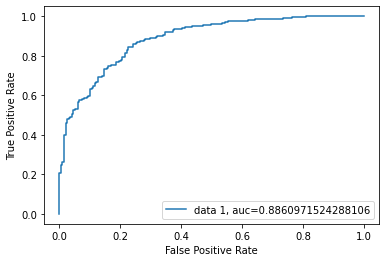

Testing Data


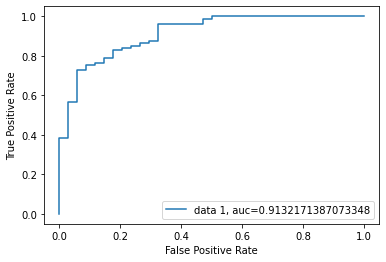

Training Data
[[146  53]
 [ 59 391]]
Accuracy:- 82.74
Precision:- 73.37
Recall:- 71.22
F-measure:- 72.28
Testing Data
[[23 11]
 [10 71]]
Accuracy:- 81.74
Precision:- 67.65
Recall:- 69.70
F-measure:- 68.66


In [261]:
logistic_model = Modeling(X_train, X_test, y_train, y_test, lr, 'Logistic Regression')
logistic_model.prediction()